# Import libs

In [2]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2 as cv2
from sklearn.model_selection import train_test_split
import random

# Exploratory data analysis (EDA)
The real data contain 6000 fingerprint for 600 subject as every subject has 10 fingerprints that represents the five fingers for every hand.
- There are three different versions of the altered data : easy-medium-hard .
- The augmentation of the data is : obliteration, central rotation, and z-cut .
- The names for every photo is in format [(subjectindex)(gender)_(finger_name).BMP]
- The finger names with their corresponding labels are:
1) index_finger ----> 0
2) little_finger ----> 1
3) middle_finger ----> 2
4) ring_finger ----> 3
5) thumb_finger ----> 4

-> We will use the real data to construct the CNN model.

In [3]:
real_dir = "E:\\BioMetric\\Project\\Real"

# load the real data and their labels
photos_names = os.listdir(real_dir)

real_img_set = []

for name in photos_names:
    real_img_set.append(cv2.imread(os.path.join(real_dir ,name) ,cv2.IMREAD_GRAYSCALE))


data = []
labels = []

for name in photos_names:
    data.append(cv2.imread(os.path.join(real_dir ,name) ,cv2.IMREAD_GRAYSCALE))
    temp = name.split("_")[4]
    if temp == "index" : labels.append(0)
    elif temp == "little" : labels.append(1)
    elif temp == "middle" : labels.append(2)
    elif temp == "ring" : labels.append(3)
    else : labels.append(4)

Creating histograms to determine the best image width and height to resize all images to that size as we don't want to remove any necessary information

{103: 5956, 298: 44}


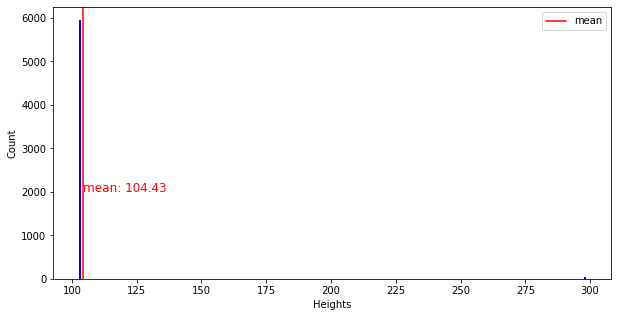

In [4]:
hist = {}
for image in data:
    height = image.shape[0]
    hist[height] = hist.get(height, 0) + 1

print(hist)

sum_height = 0
sum_num = 0

for height, num in hist.items():  # Use .items() to iterate over dictionary key-value pairs
    sum_height += height * num
    sum_num += num

mean = sum_height / sum_num

# Create a bar chart for the histogram
plt.figure(figsize=(10, 5))
plt.bar(list(hist.keys()), list(hist.values()), color="b")
plt.xlabel("Heights")
plt.ylabel("Count")

# Plot the mean value as a horizontal line
plt.axvline(x=mean, color='r', label='mean')
plt.text(mean, 2000, f'mean: {mean:.2f}', fontsize=12, color='r')

plt.legend()  # Add a legend to the plot

plt.show()

{96: 5956, 241: 44}


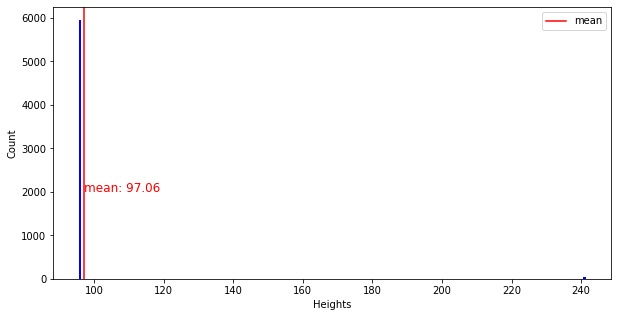

In [5]:
hist = {}
for image in data:
    width = image.shape[1]
    hist[width] = hist.get(width, 0) + 1

print(hist)

sum_width = 0
sum_num = 0

for width, num in hist.items():  # Use .items() to iterate over dictionary key-value pairs
    sum_width += width * num
    sum_num += num

mean = sum_width / sum_num

# Create a bar chart for the histogram
plt.figure(figsize=(10, 5))
plt.bar(list(hist.keys()), list(hist.values()), color="b")
plt.xlabel("Heights")
plt.ylabel("Count")

# Plot the mean value as a horizontal line
plt.axvline(x=mean, color='r', label='mean')
plt.text(mean, 2000, f'mean: {mean:.2f}', fontsize=12, color='r')

plt.legend()  # Add a legend to the plot

plt.show()

Most of the images have fixed size (96, 103) -> Therefore we resize all images to 96 x 103

In [6]:
# resizing all the data to 103X96
for i,image in enumerate(data):
    data[i] = cv2.resize(image ,(96,103))

Histogram equalization

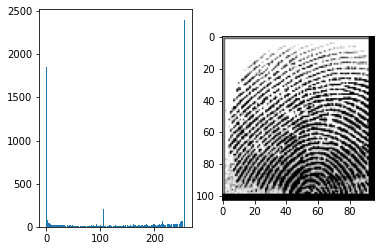

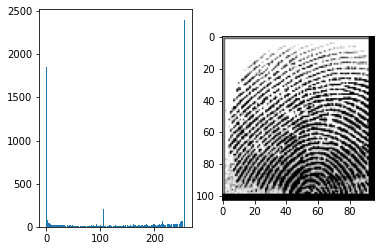

In [7]:
plt.figure()
plt.subplot(121)
plt.hist(real_img_set[4].ravel(), 256, [0,256])
plt.subplot(122)
plt.imshow(real_img_set[4], cmap='gray')
plt.show()

for image in data:
    image = cv2.equalizeHist(image)

plt.figure()
plt.subplot(121)
plt.hist(data[4].ravel(), 256, [0,256])
plt.subplot(122)
plt.imshow(data[4], cmap='gray')
plt.show()

Apply Median filtering to filter salt&pepper noises

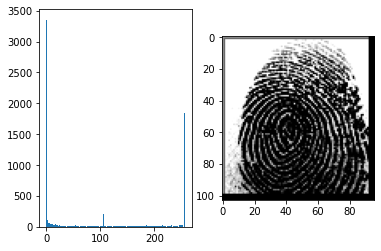

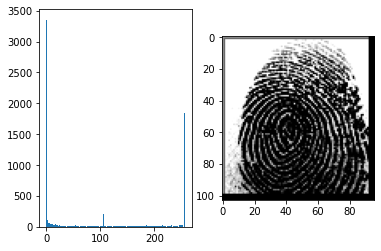

In [8]:
plt.figure()
plt.subplot(121)
plt.hist(real_img_set[55].ravel(), 256, [0,256])
plt.subplot(122)
plt.imshow(real_img_set[55], cmap='gray')
plt.show()

kernel_size = 5
for image in data:
    image = cv2.medianBlur(image, kernel_size)

plt.figure()
plt.subplot(121)
plt.hist(data[55].ravel(), 256, [0,256])
plt.subplot(122)
plt.imshow(data[55], cmap='gray')
plt.show()

Apply binarization

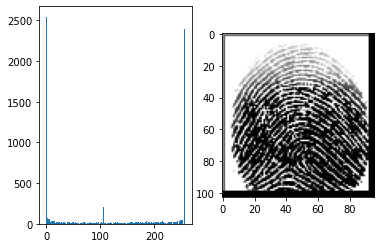

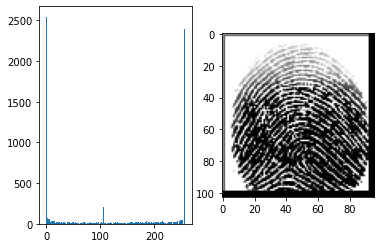

In [9]:
plt.figure()
plt.subplot(121)
plt.hist(real_img_set[46].ravel(), 256, [0,256])
plt.subplot(122)
plt.imshow(real_img_set[46], cmap='gray')
plt.show()

for i in range(len(data)):
    _, binary_image = cv2.threshold(data[i], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


plt.figure()
plt.subplot(121)
plt.hist(data[46].ravel(), 256, [0,256])
plt.subplot(122)
plt.imshow(data[46], cmap='gray')
plt.show()


# ORB

This is for recognition first. 

Average match score: 58.150371657938095
Equal Error Rate (EER): 0.0
EER Threshold: 89


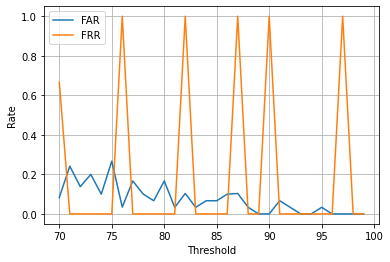

In [13]:
# Create an ORB detector
orb = cv2.ORB_create()

data_features = []

# Assuming 'data' contains your original fingerprint images
for img in data:
    keypoints, des = orb.detectAndCompute(img, None)
    data_features.append((keypoints, des))

# Number of random samples to select
num_samples = 30

# Define the directory containing altered fingerprint images (Altered-Easy)
altered_images_dir = "E:\\BioMetric\\Project\\Altered\\Altered-Easy"

# Get a list of sample files from the Altered-Easy directory
sample_files = os.listdir(altered_images_dir)

# Initialize variables to store the best matching result
best_score = 0
best_filename = None
best_image = None

accurate_count = 0
match_points_array = []

# Initialize variables to store counts
imposter_attempts = 0
genuine_attempts = 0
imposter_accepted = 0
genuine_rejected = 0

# Define a range of threshold values to sweep
threshold_range = np.arange(70, 100, 1)  # Adjust the range as needed

eer = 1.0  # Initialize EER to a high value

# Lists to store FAR and FRR values for each threshold
far_values = []
frr_values = []

# Create a FLANN-based matcher for keypoint matching
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)

# Initialize variables and lists

# Loop through each threshold
for threshold in threshold_range:
    # Reset counts for each threshold
    imposter_attempts = 0
    genuine_attempts = 0
    imposter_accepted = 0
    genuine_rejected = 0

    # Randomly select 'num_samples' samples from the list
    selected_samples = random.sample(sample_files, num_samples)

    # Loop through each selected sample image
    for sample_file in selected_samples:
        # Load the sample image
        sample_path = os.path.join(altered_images_dir, sample_file)
        sample = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)

        if sample is None:
            print("Error loading:", sample_path)
            continue

        # Initialize variables to store the best matching result for the current sample
        current_best_score = 0
        current_best_filename = None

        # Detect keypoints and compute descriptors for the sample
        keypoints_1, des1 = orb.detectAndCompute(sample, None)

        if des1 is None:
            print("No descriptors found for sample:", sample_file)
            continue

        # Loop through each real fingerprint image in the directory
        for i, (_, des2) in enumerate(data_features):
            matches = matcher.knnMatch(des1, des2, k=2)

            # Filter good matches based on Lowe's ratio test
            match_points = [m for m, n in matches if m.distance < 0.75 * n.distance]

            # Calculate a matching score as the ratio of good matches to total keypoints
            keypoints = min(len(keypoints_1), len(data_features[i][0]))
            score = len(match_points) / keypoints * 100

            if score > current_best_score:
                current_best_score = score
                current_best_filename = photos_names[i]

        # Update the best matching result for the current sample
        if current_best_score > best_score:
            best_score = current_best_score
            best_filename = current_best_filename
            best_image = data[i]

        match_points_array.append(current_best_score)     

        # Update counts based on the matching result for the current sample
        if sample_file.split("__")[0] == best_filename.split("__")[0]: 
            genuine_attempts += 1
            if current_best_score < threshold:
                genuine_rejected += 1
        else:
            imposter_attempts += 1
            if current_best_score >= threshold:
                imposter_accepted += 1

    # Calculate FAR and FRR for the current threshold
    far = imposter_accepted / imposter_attempts if imposter_attempts > 0 else 0
    frr = genuine_rejected / genuine_attempts if genuine_attempts > 0 else 0

    far_values.append(far)
    frr_values.append(frr)

    # Check if EER is achieved
    if abs(far - frr) < eer:
        eer = abs(far - frr)
        eer_threshold = threshold

print("Average match score:", np.mean(match_points_array))

# Print the EER and its corresponding threshold
print("Equal Error Rate (EER):", eer)
print("EER Threshold:", eer_threshold)

# Plot FAR and FRR curves
plt.figure()
plt.plot(threshold_range, far_values, label="FAR")
plt.plot(threshold_range, frr_values, label="FRR")
plt.xlabel("Threshold")
plt.ylabel("Rate")
plt.legend()
plt.grid(True)
plt.show()


# SIFT

Extract keypoints and descriptors for all processed real images in database

In [14]:
# Create a SIFT detector
sift = cv2.SIFT_create()

data_features = []

for i in range (0, len(data)):
    keypoints, des = sift.detectAndCompute(data[i], None)
    data_features.append((keypoints, des))

print(len(data))
print(len(data_features))

6000
6000


In [15]:
# Define the directory containing altered fingerprint images (Altered-Easy)
altered_images_dir = "E:\\BioMetric\\Project\\Altered\\Altered-Hard"

# Get a list of sample files from the Altered-Easy directory
sample_files = os.listdir(altered_images_dir)

# Number of random samples to select
num_samples = 10

# Randomly select 'num_samples' samples from the list
selected_samples = random.sample(sample_files, num_samples)


# Create a FLANN-based matcher for keypoint matching
matcher = cv2.FlannBasedMatcher({"algorithm": 1, "trees": 10}, {})

In [16]:
# Initialize variables to store the best matching result
best_score = 0
best_filename = None
best_image = None
best_kp1 = None
best_kp2 = None
best_mp = None

accurate_count = 0
match_points_array = []


# Loop through each selected sample image
for sample_file in selected_samples:
    # Load the sample image
    sample_path = os.path.join(altered_images_dir, sample_file)
    sample = cv2.imread(sample_path, cv2.IMREAD_GRAYSCALE)

    if sample is None:
        print("Error loading:", sample_path)
        continue

    # Initialize variables to store the best matching result for the current sample
    current_best_score = 0
    current_best_filename = None

    for i in range (0, len(data_features)):
        # Detect keypoints and compute descriptors for the sample and real fingerprint images
        keypoints_1, des1 = sift.detectAndCompute(sample, None)
        keypoints_2, des2 = data_features[i]

        matches = matcher.knnMatch(des1, des2, k=2)

        # Filter good matches based on Lowe's ratio test
        match_points = [p for p, q in matches if p.distance < 0.1 * q.distance]

        # Calculate a matching score as the ratio of good matches to total keypoints
        keypoints = min(len(keypoints_1), len(keypoints_2))
        score = len(match_points) / keypoints * 100

        if score > current_best_score:
            current_best_score = score
            current_best_filename = photos_names[i]

    # Update the best matching result for the current sample
    if current_best_score > best_score:
        best_score = current_best_score
        best_filename = current_best_filename
        best_image = data[i]
        best_kp1, best_kp2, best_mp = keypoints_1, keypoints_2, match_points

    # Print the best match filename and score for the current sample
    # print("Input file name:", sample_file)
    # print("Best match:", current_best_filename)
    # print("Best score:", current_best_score)
    if sample_file.split("__")[0] == current_best_filename.split("__")[0]:
        accurate_count += 1    
        match_points_array.append(current_best_score)   

print("Average match score:", np.mean(match_points_array))

# Display the overall best match result if it exists
if best_mp:
    result = cv2.drawMatches(sample, best_kp1, best_image, best_kp2, best_mp, None)
    result = cv2.resize(result, None, fx=5, fy=5)
    image = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.title("Best Match")
    plt.axis("off")
    plt.show()


Average match score: 41.3543619765523


In [17]:
# Person ID accuracy for recognition (altered-easy) -> 100% luon
print(accurate_count/num_samples)

# Adaptive threshold for fingerprint AUTHENTICATION (legit if match_score > threshold)
# TODO

1.0
